# Bag of Words Meets Bags of Popcorn

Filename: movie-review-model.ipynb \
Author: Timothy Holland \
Last updated: 14/06/2024 \
Kaggle competition: https://www.kaggle.com/c/word2vec-nlp-tutorial/data

## Data Summary

In [59]:
import pandas as pd

train_data = pd.read_csv('word2vec-nlp-tutorial/labeledTrainData.tsv', sep='\t')

# Load the test data
test_data = pd.read_csv('word2vec-nlp-tutorial/testData.tsv', sep='\t')

In [60]:
from collections import Counter

# Print the first few rows of the training data
print("First few rows of the training data:")
print(train_data.head())

# Get the total number of samples
total_train_samples = len(train_data)
total_test_samples = len(test_data)
print(f"\nTotal number of training samples: {total_train_samples}")
print(f"Total number of test samples: {total_test_samples}")

# Get the unique sentiments and their counts (only for training data)
sentiment_counts = Counter(train_data['sentiment'])
print("\nSentiment distribution (training data):")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count} ({count/total_train_samples*100:.2f}%)")

# Get the average length of the reviews
avg_train_review_length = train_data['review'].apply(len).mean()
avg_test_review_length = test_data['review'].apply(len).mean()
print(f"\nAverage training review length: {avg_train_review_length:.2f} characters")
print(f"Average test review length: {avg_test_review_length:.2f} characters")

# Get the number of unique words in the reviews (combining train and test data)
unique_words = set()
train_data['review'].str.lower().str.split().apply(unique_words.update)
test_data['review'].str.lower().str.split().apply(unique_words.update)
print(f"\nNumber of unique words (in both train and test): {len(unique_words)}")

# Print a random sample from the training data
print("\nRandom sample from training data:")
sample = train_data.sample().iloc[0]
print(f"ID: {sample['id']}")
print(f"Review: {sample['review'][:200]}...") # Print first 200 characters
print(f"Sentiment: {sample['sentiment']}")

# Calculate correlation between review length and sentiment (only for training data)
train_data['review_length'] = train_data['review'].apply(len)
correlation = train_data['review_length'].corr(train_data['sentiment'])
print(f"\nCorrelation between review length and sentiment (training data): {correlation:.4f}")

# Print the most common words (combining train and test data)
word_counts = Counter()
train_data['review'].str.lower().str.split().apply(word_counts.update)
test_data['review'].str.lower().str.split().apply(word_counts.update)
print("\nTop 10 most common words (in both train and test):")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

First few rows of the training data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...

Total number of training samples: 25000
Total number of test samples: 25000

Sentiment distribution (training data):
1: 12500 (50.00%)
0: 12500 (50.00%)

Average training review length: 1327.71 characters
Average test review length: 1296.44 characters

Number of unique words (in both train and test): 401572

Random sample from training data:
ID: 2497_8
Review: Indeed: drug use, warehouse shoot-'em-ups, 'Matrix'-esque bullet dodging, a futuristic city with a mix of Asian races, and a lonely vampire --all in the same movie-- s

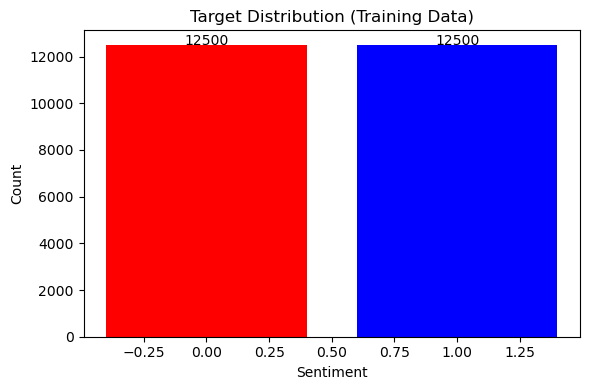

In [61]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the number of positive and negative sentiments
sentiment_counts = train_data['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Target Distribution (Training Data)')
plt.xticks(rotation=0)

# Add count labels on top of the bars
for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.tight_layout()
plt.show()

## Data Processing

#### Lemmatising

In [62]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data (uncomment these lines if you haven't downloaded them before)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Preprocessing functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply the preprocessing function to the 'review' column for both train and test data
train_data['preprocessed_review'] = train_data['review'].apply(preprocess_text)
test_data['preprocessed_review'] = test_data['review'].apply(preprocess_text)

# Print the first few rows of the preprocessed training data
print("Preprocessed training data:")
print(train_data[['id', 'sentiment', 'preprocessed_review']].head())

# Print the first few rows of the preprocessed test data
print("\nPreprocessed test data:")
print(test_data[['id', 'preprocessed_review']].head())


Preprocessed training data:
       id  sentiment                                preprocessed_review
0  5814_8          1  stuff going moment mj ive started listening mu...
1  2381_9          1  classic war world timothy hines entertaining f...
2  7759_3          0  film start manager nicholas bell giving welcom...
3  3630_4          0  must assumed praised film greatest filmed oper...
4  9495_8          1  superbly trashy wondrously unpretentious explo...

Preprocessed test data:
         id                                preprocessed_review
0  12311_10  naturally film who main theme mortality nostal...
1    8348_2  movie disaster within disaster film full great...
2    5828_4  movie kid saw tonight child loved one point ki...
3    7186_2  afraid dark left impression several different ...
4   12128_7  accurate depiction small time mob life filmed ...


#### Embedding

In [63]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

# Combine preprocessed reviews from both train and test data and train Word2Vec
all_sentences = [review.split() for review in train_data['preprocessed_review']] + \
                [review.split() for review in test_data['preprocessed_review']]

# Train Word2Vec model on all data
model = Word2Vec(all_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Derives average word vector
def get_average_word_vector(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

# Disply embedding
print("Vocabulary size:", len(model.wv.key_to_index))
print("\nDimensions of word vectors:", model.vector_size)

# Find most similar words
print(f"\nMost similar words to '{word}':")
similar_words = model.wv.most_similar(word, topn=5)
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")

# Get average vector for a sample review from training data
sample_review = train_data['preprocessed_review'].iloc[0]
avg_vector = get_average_word_vector(sample_review.split(), model, model.vector_size)
print("\nAverage vector for a sample review (training data):")
print(avg_vector)

# Calculate similarity between two reviews (one from train, one from test)
review1 = train_data['preprocessed_review'].iloc[0]
review2 = test_data['preprocessed_review'].iloc[0]
vector1 = get_average_word_vector(review1.split(), model, model.vector_size)
vector2 = get_average_word_vector(review2.split(), model, model.vector_size)
similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
print("\nSimilarity between a training and a test review:", similarity)

Vocabulary size: 164583

Dimensions of word vectors: 100

Vector for 'movie':
[ 0.07023169 -1.2495413  -2.6504536  -0.39374003  0.343533    0.18062003
  0.25031143 -0.38747808  1.6540138   0.4048017  -0.7759133   1.3159442
  0.44632742  1.7591256  -0.09775648  1.1875603   2.0129623   1.8769283
 -1.2880993   0.312952   -1.075558   -1.399599   -1.4979174  -1.0827051
  1.4608246   1.007041   -2.3724222   2.3315117  -0.06926716  1.0872163
  0.8629463   0.7681881   0.3802228  -0.22514378 -1.1041418   0.14832969
 -1.2189969   0.4234327   0.6404939  -1.3388249   0.28520283  0.27843508
  0.9903926   1.1250054   0.18074131  0.75676894 -0.9947662  -2.2608259
  0.85241467  0.33230883  2.1822038  -0.6053964  -2.2275007  -3.3499632
 -0.16972587 -0.30873683 -0.15229201 -0.8474001  -1.1318407  -0.07671762
  0.7647221   0.63344824  1.352239    0.86227703 -1.5733224   1.5791677
  1.3189322   0.3778864  -2.6324553   1.6595947  -2.711635   -0.10403493
  0.855724    0.5977808  -0.4823609  -0.11653238 -0.5

#### Feature Vectors

In [64]:
import numpy as np
import pandas as pd

# Feature vectors of each review in train & test
X_train = np.array([get_average_word_vector(review.split(), model, model.vector_size) for review in train_data['preprocessed_review']])
y_train = train_data['sentiment']

X_test = np.array([get_average_word_vector(review.split(), model, model.vector_size) for review in test_data['preprocessed_review']])

# Convert sentiment labels to binary (0 and 1) for training data
y_train = pd.get_dummies(y_train, drop_first=True).iloc[:, 0]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (25000, 100)
Shape of y_train: (25000,)
Shape of X_test: (25000, 100)


## Models

#### KNN

In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Create the KNN classifier & grid search hyperparameters
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Derive best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}


#### Logistic Regression

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score

# Hyperparameters
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Instantiate LR & grid search
model = LogisticRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_lr_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate the best model using cross-validation
cv_scores = cross_val_score(best_lr_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Fit best model
best_lr_model.fit(X_train, y_train)

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-validation scores: [0.93033648 0.93341488 0.926136   0.93112368 0.92490144]
Mean cross-validation score: 0.9291824959999999


LogisticRegression(C=1, solver='liblinear')

In [100]:
y_pred_prob = best_lr_model.predict_proba(X_test)[:, 1]
best_model = best_lr_model

## Predictions

In [101]:
import csv

# Predictions & conversions for submission
y_pred = best_model.predict(X_test)
y_pred_int = y_pred.astype(int)

submission_df = pd.DataFrame({'id': test_data['id'], 'sentiment': y_pred_int})
submission_df['id'] = submission_df['id'].astype(str)

# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
